# Introduction

This notebook contains, step-by-step, the procedure I followed, from feature engineering to final predictions, for the "House Prices: Advanced Regression Techniques" Kaggle Competition and follows the EDA presented on the other notebook. It results on RMSE = 0.14179. After the feature engineering part, i tried some base models and combined them to a simple averaging ensemble and a stacked model.

When i find some time, i aim to experiment with different features as inputs, base and stacked models for further improvement.

The notebook is organized on the following sections:

- [Feature Engineering](#section1)
- [Data Preparation](#section2)
- [Feature Selection](#section3)
- [Base Models](#section4)
- [Ensemble Model](#section5)
- [Stacked Model](#section6)
- [Keras Model](#section7)

# Import libraries and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.feature_selection import RFECV
from sklearn.base import clone
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, \
RandomForestRegressor, VotingClassifier
from xgboost import XGBRegressor

% matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

C:\Users\asfak\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load data
train = pd.read_csv("train_house.csv")
test = pd.read_csv("test_house.csv")

In [3]:
train.shape, test.shape

((1460, 81), (1459, 80))

<a id="section1"></a>

# Feature Engineering

In [4]:
def DropLargeNAs(df):
    
    """
    Drop columns that have more than 50% missing values
    """
    
    cols_to_keep = [col for col in df.columns if (df[col].isnull().sum() * 100) / (df.shape[0]) < 40]
    cols_to_remove = [col for col in df.columns if col not in cols_to_keep]
    
    return df[cols_to_keep]



def ImputeMissingValues(df):
    
    """
    For categorical features fill NAs with mode
    For numerical features fill NAs with median
    """
    
    cols_with_nas = [col for col in df.columns if (df[col].isnull().sum() * 100) / (df.shape[0]) > 0]
    
    # Impute numerical values
    for col in cols_with_nas:
        
        if df[col].dtype == "object":
            df[col] = df[col].fillna(df[col].dropna().mode()[0])
            
        else:
            df[col] = df[col].fillna(df[col].dropna().median())

    
    return df



def LogTargetVariable(df):
    
    """
    Take the log of the target variable.
    Obviosuly this function can be applied only to training set.
    """
    
    df["Log_SalePrice"] = df["SalePrice"].map(lambda x: np.log10(x))
    return df



def MapFeatures(df):
    
    """
    Some features in the given dataset are encoded as categorical, whereas they are actually numerical,
    since there is an inherent ordering. In the same sense, there are numerical features that are actually categorical.
    """
    
    # Map ctegorical to numerical
    df["LotShape"] = df["LotShape"].map({'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3})
    df["ExterQual"] = df["ExterQual"].map({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0})
    df["ExterCond"] = df["ExterCond"].map({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0})
    df["BsmtQual"] = df["BsmtQual"].map({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0})
    df["BsmtCond"] = df["BsmtCond"].map({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0})
    df["BsmtExposure"] = df["BsmtExposure"].map({"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0})
    df["HeatingQC"] = df["HeatingQC"].map({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0})
    df["KitchenQual"] = df["KitchenQual"].map({"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0})
    df["GarageQual"] = df["GarageQual"].map({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0})
    df["GarageCond"] = df["GarageCond"].map({"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0})
    
    
    # Map numerical to categorical
    df["MSSubClass"] = df["MSSubClass"].map({20: "SC20", 60: "SC60", 50: "SC50", 120: "SC120", 30: "SC30", 160: "SC160", 
                                             70: "SC70", 80: "SC80", 90: "SC90", 190: "SC190", 85: "SC85", 75: "SC75", 
                                             45: "SC45", 180: "SC180", 40: "SC40"})
    
    ## Alterantively all in one
    ##df3 = df3.replace({"LotShape": {'Reg': , 'IR1': , 'IR2': , 'IR3': }}, ....})
    
    return df



def NewFeatures(df):
    
    """
    Create new features from the original ones.
    """
    
    # GrLivArea
    df["GrLivArea_log"] = df["GrLivArea"].map(lambda x: np.log10(x))
    
    # LotFrontage
    df["LotFrontage_log"] = df["LotFrontage"].map(lambda x: np.log10(x+10))
    df["LotFrontage_sqrt"] = df["LotFrontage"].map(lambda x: np.sqrt(x+10))
    
    # Lot Area
    df["LotArea_log"] = df["LotArea"].map(lambda x: np.log10(x+10))
    df["LotArea_sqrt"] = df["LotArea"].map(lambda x: np.sqrt(x+10))
    
    # MasVnrArea
    df["MasVnrArea_log"] = df["MasVnrArea"].map(lambda x: np.log10(x+10))
    df["MasVnrArea_sqrt"] = df["MasVnrArea"].map(lambda x: np.sqrt(x+10))
    
    # BsmtFinSF1
    df["BsmtFinSF1_log"] = df["BsmtFinSF1"].map(lambda x: np.log10(x+10))
    df["BsmtFinSF1_sqrt"] = df["BsmtFinSF1"].map(lambda x: np.sqrt(x+10))
    
    
    # BsmtUnfSF
    df["BsmtUnfSF_log"] = df["BsmtUnfSF"].map(lambda x: np.log10(x+100))
    df["BsmtUnfSF_sqrt"] = df["BsmtUnfSF"].map(lambda x: np.sqrt(x+10))
    
    # 1stFlrSF
    df["1stFlrSF_log"] = df["1stFlrSF"].map(lambda x: np.log10(x))
    df["1stFlrSF_sqrt"] = df["1stFlrSF"].map(lambda x: np.sqrt(x))
    
    # 2ndFlrSF
    df["2ndFlrSF_log"] = df["2ndFlrSF"].map(lambda x: np.log10(x+100))
    df["2ndFlrSF_sqrt"] = df["2ndFlrSF"].map(lambda x: np.sqrt(x+100))
    
    # GarageArea
    df["GarageArea_log"] = df["GarageArea"].map(lambda x: np.log10(x+100))
    df["GarageArea_sqrt"] = df["GarageArea"].map(lambda x: np.sqrt(x+100))
    
    # WoodDeckSF
    df["WoodDeckSF_log"] = df["WoodDeckSF"].map(lambda x: np.log10(x+100))
    df["WoodDeckSF_sqrt"] = df["WoodDeckSF"].map(lambda x: np.sqrt(x+100))
    
    # OpenPorchSF
    df["OpenPorchSF_log"] = df["OpenPorchSF"].map(lambda x: np.log10(x+100))
    df["OpenPorchSF_sqrt"] = df["OpenPorchSF"].map(lambda x: np.sqrt(x+100))
    
    # Overall Score
    df["OverallScore"] = df["OverallQual"] * df["OverallCond"]
    
    # Exterior Score
    df["ExtScore"] = df["ExterQual"] * df["ExterCond"]
    
    # Garage Score
    df["GarageScore"] = df["GarageQual"] * df["GarageCond"]
    
    # Bsmt Score
    df["BsmtScore"] = df["BsmtQual"] * df["BsmtCond"]
    
    # Total SF
    df["TotalSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
    
    # Outdoor spaces
    df["OutdoorSF"] = df["GarageArea"] + df["WoodDeckSF"] + df["OpenPorchSF"] + df["EnclosedPorch"] + \
                      df["3SsnPorch"] + df["ScreenPorch"] + df["PoolArea"]
    
    
    return df


    
def dropUselessFeatures(df):
    
    useless_features = ["Id", "Street", "Utilities", "LandSlope", "Condition2", "RoofStyle", "RoofMatl", "BsmtFinType1", "BsmtFinType2",
                        "BsmtFinSF2", "LowQualFinSF", "BsmtFullBath", "BsmtHalfBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr",
                        "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "MoSold", "YrSold"
                       ]
    
    df.drop(useless_features, axis = 1, inplace = True)
    
    return df


def pipeline_func(data, fncs):
    
    """
    Create a pipeline of functions to apply to train and test datasets.
    
    The function reduce(func, seq) continually applies the function func() to the sequence seq. It returns a single value. 
    If seq = [ s1, s2, s3, ... , sn ], calling reduce(func, seq) works like this:
        --- At first the first two elements of seq will be applied to func, i.e. func(s1,s2). The list on which reduce()
            works looks now like this: [ func(s1, s2), s3, ... , sn ].
        --- In the next step func will be applied on the previous result and the third element of the list, i.e. 
            func(func(s1, s2),s3).
        --- The list looks like this now: [ func(func(s1, s2),s3), ... , sn ].
    """
    
    return reduce(lambda a,x: x(a), fncs, data)
    

Let's prepeare train and test sets:

In [5]:
train_functions = [DropLargeNAs, ImputeMissingValues, LogTargetVariable, MapFeatures, NewFeatures, dropUselessFeatures]
test_functions = [DropLargeNAs, ImputeMissingValues, MapFeatures, NewFeatures, dropUselessFeatures]

In [6]:
train_eng = pipeline_func(train, train_functions)
test_eng = pipeline_func(test, test_functions)

In [7]:
train_eng.shape, test_eng.shape

((1460, 82), (1459, 80))

In [8]:
train_eng.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,SaleType,SaleCondition,SalePrice,Log_SalePrice,GrLivArea_log,LotFrontage_log,LotFrontage_sqrt,LotArea_log,LotArea_sqrt,MasVnrArea_log,MasVnrArea_sqrt,BsmtFinSF1_log,BsmtFinSF1_sqrt,BsmtUnfSF_log,BsmtUnfSF_sqrt,1stFlrSF_log,1stFlrSF_sqrt,2ndFlrSF_log,2ndFlrSF_sqrt,GarageArea_log,GarageArea_sqrt,WoodDeckSF_log,WoodDeckSF_sqrt,OpenPorchSF_log,OpenPorchSF_sqrt,OverallScore,ExtScore,GarageScore,BsmtScore,TotalSF,OutdoorSF
0,SC60,RL,65.0,8450,0,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,VinylSd,VinylSd,BrkFace,196.0,3,2,PConc,4,3,1,706,150,856,GasA,4,Y,SBrkr,856,854,1710,2,3,8,Typ,0,Attchd,2003.0,RFn,2,548,3,3,Y,0,61,0,WD,Normal,208500,5.319106,3.232996,1.875061,8.660254,3.927370,91.978258,2.313867,14.352700,2.854913,26.758176,2.397940,12.649111,2.932474,29.257478,2.979548,30.886890,2.811575,25.455844,2.000000,10.000000,2.206826,12.688578,35,6,9,12,1710,609
1,SC20,RL,80.0,9600,0,Lvl,FR2,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,MetalSd,MetalSd,None,0.0,2,2,CBlock,4,3,4,978,284,1262,GasA,4,Y,SBrkr,1262,0,1262,2,2,6,Typ,1,Attchd,1976.0,RFn,2,460,3,3,Y,298,0,0,WD,Normal,181500,5.258877,3.101059,1.954243,9.486833,3.982723,98.030607,1.000000,3.162278,2.994757,31.432467,2.584331,17.146428,3.101059,35.524639,2.000000,10.000000,2.748188,23.664319,2.599883,19.949937,2.000000,10.000000,48,4,9,12,1262,758
2,SC60,RL,68.0,11250,1,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,5,2001,2002,VinylSd,VinylSd,BrkFace,162.0,3,2,PConc,4,3,2,486,434,920,GasA,4,Y,SBrkr,920,866,1786,2,3,6,Typ,1,Attchd,2001.0,RFn,2,608,3,3,Y,0,42,0,WD,Normal,223500,5.349278,3.251881,1.892095,8.831761,4.051538,106.113147,2.235528,13.114877,2.695482,22.271057,2.727541,21.071308,2.963788,30.331502,2.984977,31.080541,2.850033,26.608269,2.000000,10.000000,2.152288,11.916375,35,6,9,12,1786,650
3,SC70,RL,60.0,9550,1,Lvl,Corner,Crawfor,Norm,1Fam,2Story,7,5,1915,1970,Wd Sdng,Wd Shng,None,0.0,2,2,BrkTil,3,4,1,216,540,756,GasA,3,Y,SBrkr,961,756,1717,1,3,7,Typ,1,Detchd,1998.0,Unf,3,642,3,3,Y,0,35,272,WD,Abnorml,140000,5.146128,3.234770,1.845098,8.366600,3.980458,97.775252,1.000000,3.162278,2.354108,15.033296,2.806180,23.452079,2.982723,31.000000,2.932474,29.257478,2.870404,27.239677,2.000000,10.000000,2.130334,11.618950,35,4,9,12,1717,949
4,SC60,RL,84.0,14260,1,Lvl,FR2,NoRidge,Norm,1Fam,2Story,8,5,2000,2000,VinylSd,VinylSd,BrkFace,350.0,3,2,PConc,4,3,3,655,490,1145,GasA,4,Y,SBrkr,1145,1053,2198,2,3,9,Typ,1,Attchd,2000.0,RFn,3,836,3,3,Y,192,84,0,WD,Normal,250000,5.397940,3.342028,1.973128,9.695360,4.154424,119.457105,2.556303,18.973666,2.822822,25.787594,2.770852,22.360680,3.058805,33.837849,3.061829,33.955854,2.971276,30.594117,2.465383,17.088007,2.264818,13.564660,40,6,9,12,2198,1112


In [9]:
test_eng.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,SaleType,SaleCondition,GrLivArea_log,LotFrontage_log,LotFrontage_sqrt,LotArea_log,LotArea_sqrt,MasVnrArea_log,MasVnrArea_sqrt,BsmtFinSF1_log,BsmtFinSF1_sqrt,BsmtUnfSF_log,BsmtUnfSF_sqrt,1stFlrSF_log,1stFlrSF_sqrt,2ndFlrSF_log,2ndFlrSF_sqrt,GarageArea_log,GarageArea_sqrt,WoodDeckSF_log,WoodDeckSF_sqrt,OpenPorchSF_log,OpenPorchSF_sqrt,OverallScore,ExtScore,GarageScore,BsmtScore,TotalSF,OutdoorSF
0,SC20,RH,80.0,11622,0,Lvl,Inside,NAmes,Feedr,1Fam,1Story,5,6,1961,1961,VinylSd,VinylSd,None,0.0,2,2,CBlock,3,3,1,468.0,270.0,882.0,GasA,2,Y,SBrkr,896,0,896,1,2,5,Typ,0,Attchd,1961.0,Unf,1.0,730.0,3,3,Y,140,0,0,WD,Normal,2.952308,1.954243,9.486833,4.065654,107.851750,1.000000,3.162278,2.679428,21.863211,2.568202,16.733201,2.952308,29.933259,2.000000,10.000000,2.919078,28.809721,2.380211,15.491933,2.000000,10.000000,30,4,9,9,896,990.0
1,SC20,RL,81.0,14267,1,Lvl,Corner,NAmes,Norm,1Fam,1Story,6,6,1958,1958,Wd Sdng,Wd Sdng,BrkFace,108.0,2,2,CBlock,3,3,1,923.0,406.0,1329.0,GasA,2,Y,SBrkr,1329,0,1329,1,3,6,Typ,0,Attchd,1958.0,Unf,1.0,312.0,3,3,Y,393,36,0,WD,Normal,3.123525,1.959041,9.539392,4.154637,119.486401,2.071882,10.862780,2.969882,30.545049,2.704151,20.396078,3.123525,36.455452,2.000000,10.000000,2.614897,20.297783,2.692847,22.203603,2.133539,11.661904,36,4,9,9,1329,741.0
2,SC60,RL,74.0,13830,1,Lvl,Inside,Gilbert,Norm,1Fam,2Story,5,5,1997,1998,VinylSd,VinylSd,None,0.0,2,2,PConc,4,3,1,791.0,137.0,928.0,GasA,3,Y,SBrkr,928,701,1629,2,2,6,Typ,1,Attchd,1997.0,Fin,2.0,482.0,3,3,Y,212,34,0,WD,Normal,3.211921,1.924279,9.165151,4.141136,117.643529,1.000000,3.162278,2.903633,28.301943,2.374748,12.124356,2.967548,30.463092,2.903633,28.301943,2.764923,24.124676,2.494155,17.663522,2.127105,11.575837,25,4,9,12,1629,728.0
3,SC60,RL,78.0,9978,1,Lvl,Inside,Gilbert,Norm,1Fam,2Story,6,6,1998,1998,VinylSd,VinylSd,BrkFace,20.0,2,2,PConc,3,3,1,602.0,324.0,926.0,GasA,4,Y,SBrkr,926,678,1604,2,3,7,Typ,1,Attchd,1998.0,Fin,2.0,470.0,3,3,Y,360,36,0,WD,Normal,3.205204,1.944483,9.380832,3.999479,99.939982,1.477121,5.477226,2.786751,24.738634,2.627366,18.275667,2.966611,30.430248,2.890980,27.892651,2.755875,23.874673,2.662758,21.447611,2.133539,11.661904,36,4,9,9,1604,866.0
4,SC120,RL,43.0,5005,1,HLS,Inside,StoneBr,Norm,TwnhsE,1Story,8,5,1992,1992,HdBoard,HdBoard,None,0.0,3,2,PConc,4,3,1,263.0,1017.0,1280.0,GasA,4,Y,SBrkr,1280,0,1280,2,3,5,Typ,0,Attchd,1992.0,RFn,2.0,506.0,3,3,Y,0,82,0,WD,Normal,3.107210,1.724276,7.280110,3.700271,70.816665,1.000000,3.162278,2.436163,16.522712,3.048053,32.046841,3.107210,35.777088,2.000000,10.000000,2.782473,24.617067,2.000000,10.000000,2.260071,13.490738,40,6,9,12,1280,732.0


<a id="section2"></a>

# Data preparation

In [10]:
def PrepareData(df, dataset):
    
    """
    Create dummy variables and normalize data for training
    """
    
    # Split features and target
    if dataset == "train":
        
        target = ["Log_SalePrice", "SalePrice"]
        c = [col for col in df.columns if col not in target]
        X = df[c]
        y = df["Log_SalePrice"]
        
    else:
        
        X = df
        y = None
        
    # Create dummy variables
    X = pd.get_dummies(df)
    
    # Normalize data
    X_scaled = StandardScaler().fit_transform(X)
    X = pd.DataFrame(X_scaled, index = X.index, columns = X.columns)
    
    return X, y

In [11]:
X, y = PrepareData(train_eng, "train")

In [12]:
X.shape, y.shape

((1460, 225), (1460,))

In [13]:
test_final, _ = PrepareData(test_eng, "test")

<a id="section3"></a>

# Feature Selection

Feature selection constitutes one of the most important steps in the whole ML pipeline. For the purposes of this competition we considered two ways of feature selection:

- Based on the EDA analysis of the previous notebook (new features + feature correlation + RF feature importance) I "manually" selected a set of features.<p>

- Using RFECV (Recursive Feature Elimination and Cross-Validated selection of the best number of features). For more info about the technique, check [here](https://topepo.github.io/caret/recursive-feature-elimination.html).

### Recursive Feature Elimination

In [14]:
def rmse(y, y_pred):
    
    return np.sqrt(mean_squared_error(y, y_pred))

rmse_scorer = make_scorer(rmse)

In [15]:
estimator = RandomForestRegressor()

In [16]:
selector = RFECV(estimator, cv = 5, scoring = rmse_scorer)
selector

RFECV(cv=5,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   n_jobs=1, scoring=make_scorer(rmse), step=1, verbose=0)

In [17]:
% time selector.fit(X,y)

Wall time: 3min 20s


RFECV(cv=5,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   n_jobs=1, scoring=make_scorer(rmse), step=1, verbose=0)

In [18]:
print("The number of selected features is: {}".format(selector.n_features_))
#features_kept = X.columns.values[selector.support_]

The number of selected features is: 148


In [19]:
# X_train = selector.transform(X_train)  
# X_test = selector.transform(X_test)

# # # transform it to a numpy array so later we can feed it to a neural network
# # y_train = y_train.values 

### Features from EDA

At the specific kernel, we will use as features the ones we concluded from the EDA of the previous notebook.

In [20]:
# best_features = ['OverallQual',
#                  'YearBuilt',
#                  'TotalBsmtSF',
#                  'GrLivArea',
#                  'KitchenQual',
#                  'GarageYrBlt',
#                  'GarageCars',
#                  '1stFlrSF_log',
#                  'OverallScore',
#                  'BsmtScore'
#                 ]

best_features = ['OverallQual',
                 'YearBuilt',
                 'ExterQual',
                 'TotalBsmtSF',
                 '1stFlrSF',
                 'GrLivArea',
                 'KitchenQual',
                 'GarageYrBlt',
                 'GarageCars',
                 'GarageArea',
                 'GrLivArea_log',
                 '1stFlrSF_log',
                 'GarageArea_log',
                 'OverallScore',
                 'BsmtScore',
                 'TotalSF',
                 'OutdoorSF'
                ]

In [21]:
X =  X[best_features]

In [22]:
X.shape, y.shape

((1460, 17), (1460,))

In [23]:
test_final = test_final[best_features]

In [24]:
test_final.shape

(1459, 17)

# Cross Validation Evaluation

In [25]:
scorer = make_scorer(mean_squared_error)
n_folds = 5

def rmse_cv(model):
    
    rmse = np.sqrt(cross_val_score(estimator = model,
                                   X = X,
                                   y = y, 
                                   cv = KFold(n_splits = n_folds),
                                   scoring = scorer))
    return rmse


def BaseModel(clf, clf_name):
    
    cv_score = rmse_cv(clf)
    
    print("{} CV scores: {}\n".format(clf_name, cv_score))
    print("{} mean CV score: {}\n".format(clf_name, cv_score.mean()))
    
    return cv_score.mean()

# Train/Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 345)

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1168, 17), (1168,), (292, 17), (292,))

<a id="section4"></a>

# Base Models

### Ridge

In [28]:
alphas_ridge = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 25, 30, 50, 60, 75, 85, 100, 200]
ridge_cv = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas_ridge]
print("Ridge best score: {} for alpha: {}".format(np.min(ridge_cv), alphas_ridge[np.argmin(ridge_cv)]))

Ridge best score: 0.06487808227708855 for alpha: 0.01


In [29]:
# plt.plot(alphas_ridge, ridge_cv)
# plt.title("Ridge Regression")
# plt.xlabel("alphas")
# plt.ylabel("Mean CV rmse")

### Lasso

In [30]:
alphas_lasso = [0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 1]
lasso_cv = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas_lasso]
print("Lasso best score: {} for alpha: {}".format(np.min(lasso_cv), alphas_lasso[np.argmin(lasso_cv)]))

Lasso best score: 0.06487998791458632 for alpha: 0.0001


In [31]:
# plt.plot(alphas_lasso, lasso_cv)
# plt.title("Lasso Regression")
# plt.xlabel("alphas")
# plt.ylabel("Mean CV rmse")

### Random Forest Regressor

In [32]:
rfg = RandomForestRegressor(n_estimators = 500, max_depth = 10)
rfg_cv_mean = BaseModel(rfg, "Random Forest Regressor")

Random Forest Regressor CV scores: [ 0.06405145  0.07376121  0.06668511  0.0556954   0.06572797]

Random Forest Regressor mean CV score: 0.06518422797615883



### Extra Trees Regressor

In [33]:
ext = ExtraTreesRegressor(n_estimators = 500, max_depth = 10)
ext_cv_mean = BaseModel(ext, "Extra Trees Regressor")

Extra Trees Regressor CV scores: [ 0.06206319  0.07558802  0.06611287  0.05698148  0.0642952 ]

Extra Trees Regressor mean CV score: 0.06500815308474615



### Gradient Boosting Regressor

In [34]:
gb = GradientBoostingRegressor(n_estimators = 500, max_depth = 10, learning_rate = 0.01)
gb_cv_mean = BaseModel(gb, "Gradient Boosting Regressor")

Gradient Boosting Regressor CV scores: [ 0.06993498  0.08291371  0.06846712  0.06285588  0.07921343]

Gradient Boosting Regressor mean CV score: 0.07267702612498476



### AdaBoost Regressor

In [35]:
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.05, loss="exponential")
ada_cv_mean = BaseModel(ada, "AdaBoost Regressor")

AdaBoost Regressor CV scores: [ 0.0792276   0.08007622  0.07880331  0.07172003  0.07905065]

AdaBoost Regressor mean CV score: 0.0777755623420183



### XGBoost Regressor

In [36]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05) #best model after stacked
xgb_cv_mean = BaseModel(xgb, "XGBoost Regressor")

XGBoost Regressor CV scores: [ 0.05799926  0.07219217  0.06176055  0.05408098  0.0577495 ]

XGBoost Regressor mean CV score: 0.06075649179501998



XGBoost seems to perform better than any other predictor, so we will use GridSearchCV to find the optimal hyperparameters.

## Hyperparameter tuning

In [37]:
rfg_grid_params = {"n_estimators": [120, 300, 500, 800, 1200],
                   "max_depth": [5, 8, 15, 25, 30, None]
                  }

ext_grid_params = {"n_estimators": [120, 300, 500, 800, 1200],
                   "max_depth": [5, 8, 15, 25, 30, None]
                  }

gb_grid_params = {"n_estimators": [100, 200, 300, 500, 800, 1000],
                  "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
                  "max_depth": [5,6,7,12]
                 }

ada_grid_params = {"n_estimators": [100, 200, 300, 500, 800, 1000],
                   "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5]
                  }

xgboost_grid_params = {"n_estimators": [100, 200, 300, 500, 800, 1000],
                       "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
                       "max_depth": [5,6,7,12]
                       }

In [38]:
def neg_rmse(y, y_pred):
    
    return -np.sqrt(mean_squared_error(y, y_pred))

neg_rmse_scorer = make_scorer(neg_rmse)

In [39]:
best_scores = []
best_params = []
best_models = []
rmse_on_xtest = []

models = [RandomForestRegressor(), ExtraTreesRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(), XGBRegressor()]
grids = [rfg_grid_params, ext_grid_params, gb_grid_params, ada_grid_params, xgboost_grid_params]


   
for i in range(len(models)):

    # Define grid
    grid = GridSearchCV(models[i], 
                        param_grid = grids[i], 
                        scoring = neg_rmse_scorer, 
                        cv = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 23))

    # Fit grid on train data
    % time grid.fit(X_train, y_train)

    # Store best score
    best_scores.append(grid.best_score_)

    # Store best params
    best_params.append(grid.best_params_)

    # Store best model
    best_models.append(grid.best_estimator_)

    # Predict on test
    pred = grid.predict(X_test)

    # rmse
    rmse_on_xtest.append((np.sqrt(mean_squared_error(y_test, pred))))

    

C:\Users\asfak\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Wall time: 9min 15s


C:\Users\asfak\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Wall time: 4min 38s


C:\Users\asfak\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Wall time: 17min 41s


C:\Users\asfak\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Wall time: 4min 22s


C:\Users\asfak\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Wall time: 3min 54s


In [40]:
m = ["Random Forest Regressor", "Extra Trees Regressor", "Gradient Boosting Regressor", "AdaBoost Regressor", "XGBoost Regressor"]

for i in range(len(models)):
    
    print("{}'s test score: {} for {}\n".format(m[i], rmse_on_xtest[i], best_params[i]))

Random Forest Regressor's test score: 0.06400432877303343 for {'max_depth': 25, 'n_estimators': 300}

Extra Trees Regressor's test score: 0.06524588367965545 for {'max_depth': 25, 'n_estimators': 120}

Gradient Boosting Regressor's test score: 0.061401803738010255 for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}

AdaBoost Regressor's test score: 0.07926117177459117 for {'learning_rate': 0.5, 'n_estimators': 100}

XGBoost Regressor's test score: 0.062017317913326216 for {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}



In [41]:
rfg_cv_preds = best_models[0].predict(X_test)
ext_cv_preds = best_models[1].predict(X_test)
gb_cv_preds = best_models[2].predict(X_test)
ada_cv_preds = best_models[3].predict(X_test)
xgb_cv_preds = best_models[4].predict(X_test)

predictions = pd.DataFrame({"RFG": 10**rfg_cv_preds,
                            "EXT": 10**ext_cv_preds, 
                            "GB": 10**gb_cv_preds,
                            "ADA": 10**ada_cv_preds,
                            "XGB": 10**xgb_cv_preds})

In [42]:
predictions

,ADA,EXT,GB,RFG,XGB
0,305573.813020,329082.985960,301085.622535,309266.057668,315661.968750
1,185706.487245,175353.238201,171566.084494,174383.377666,171901.078125
2,87628.031644,100018.482950,99202.734520,95612.791853,84543.859375
3,50949.165272,48316.686679,38888.951776,50374.102230,34492.976562
4,101094.840703,124326.654905,125524.636063,124305.473324,124196.281250
5,120361.127601,154183.915955,159203.369689,156415.631937,146953.375000
6,117309.088607,116126.966213,112447.776883,109301.713312,113650.054688
7,90643.033775,117889.293655,114258.461442,118357.734081,115866.703125
8,431625.940866,480051.228657,628248.235512,545119.536708,612997.125000
9,121217.123099,144222.646493,146798.612101,144767.754545,145982.375000


Let's take a look at how correlated are the predictions of the different models. The reason to do that, is because when you implement an ensemble/stacking model, you want your predictors to be as __dissimilar__ as possible, e.g. you want them to make __different mistakes__. If you have different models, that means that each model has captured different patterns of the data and an ensemble/stacking model is highly probable to outperform them.

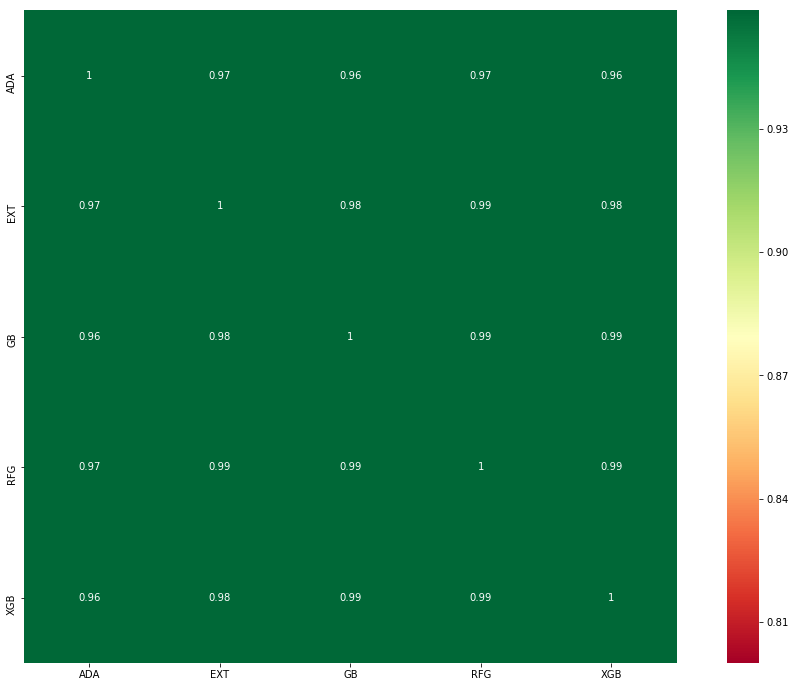

In [43]:
corrmat = predictions.corr()
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(corrmat, vmax=.8, square=True, annot = True, cmap="RdYlGn")

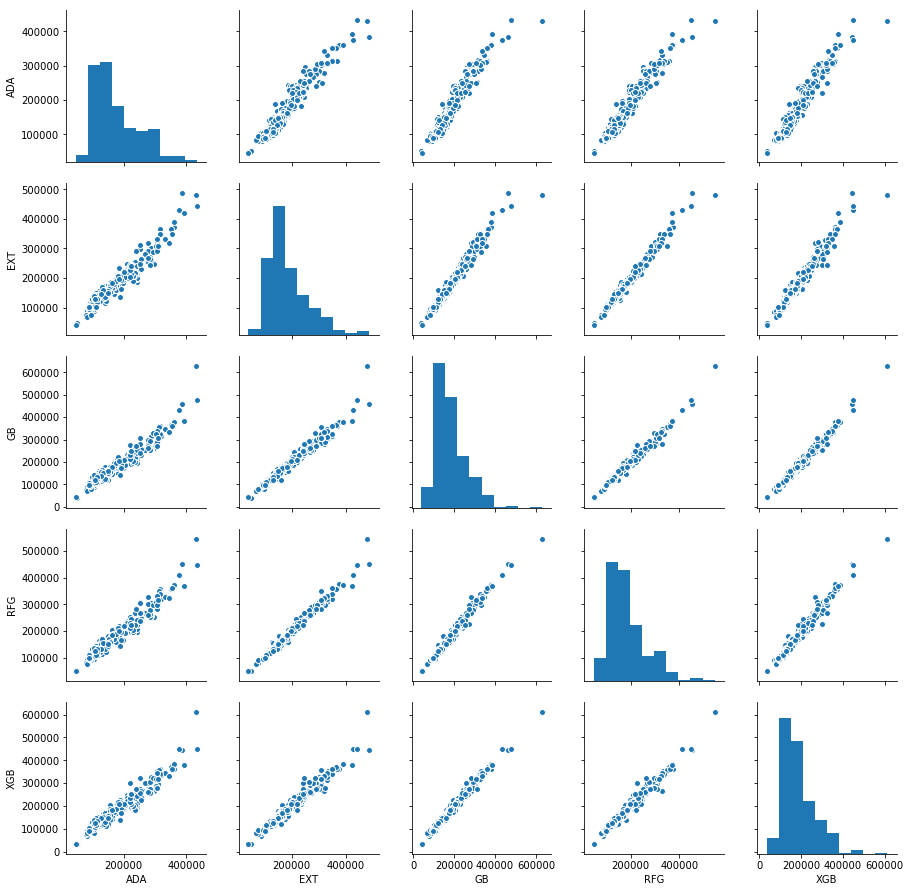

In [44]:
sns.pairplot(predictions)

From the above graphs it is obvious that all of the models are highly correlated. Although correlation in the context of regression is not necessarily bad (e.g. two models can be highly correlated but one can be much more accurate than the other), we may need to use only the ones that are the least correlated in ensemble models.

<a id="section5"></a>

# Ensemble Model

In [45]:
class EnsembleRegressor(object):
    
    def __init__(self, regressors = None):
        self.regressors = regressors
        
    def fit(self, x_train, y_train):
        for regressor in self.regressors:
            regressor.fit(x_train, y_train)
            
    def predict(self, x_test):
        self.predictions = list()
        for regressor in self.regressors:
            self.predictions.append(regressor.predict(x_test).ravel())
            
        return np.mean(self.predictions, axis = 0)
        

In [46]:
m1 = RandomForestRegressor(**best_params[0])
m2 = ExtraTreesRegressor(**best_params[1])
m3 = GradientBoostingRegressor(**best_params[2])
m4 = AdaBoostRegressor(**best_params[3])
m5 = XGBRegressor(**best_params[4])

In [47]:
ens = EnsembleRegressor([m1,m2,m3,m4,m5])

In [48]:
ens.fit(X_train, y_train)

In [49]:
p = ens.predict(X_test)

In [50]:
np.sqrt(mean_squared_error(y_test, p))

0.061699723128326368

<a id="section6"></a>

# Stacking

In [51]:
class StackingAveragedModels(object):
    
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [52]:
stacked_model = StackingAveragedModels(base_models = (m1,m4,m5),
                                       meta_model = Lasso(alpha = 0.0003))
                                       #meta_model = XGBRegressor(n_estimators=500, learning_rate=0.05))

In [53]:
% time stacked_model.fit(X_train.values, y_train.values)

Wall time: 10.2 s


In [54]:
pred_stacked = stacked_model.predict(X_test.values)

In [55]:
np.sqrt(mean_squared_error(y_test, pred_stacked))

0.060291232267227851

<a id="section7"></a>

# Try a Keras model

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import Callback
from keras import backend as K

Using Theano backend.


In [57]:
import keras
print(keras.__version__)

2.1.2


In [58]:
n_features = X.shape[1]
n_features

17

In [59]:
def Model():
    
    model = Sequential()
    
    model.add(Dense(256, input_shape = (n_features,)))
    model.add(Activation("sigmoid"))
    model.add(Dropout(0.4))
    
    model.add(Dense(64, input_shape = (256,)))
    model.add(Activation("sigmoid"))
    model.add(Dropout(0.4))
    
    model.add(Dense(32, input_shape = (64,)))
    model.add(Activation("sigmoid"))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, input_shape = (32,)))
    model.add(Activation("sigmoid"))
    
    return model


def Model1():
    
    model = Sequential()
    
    model.add(Dense(256, input_shape = (n_features,)))
    model.add(Activation("relu"))
    model.add(Dropout(0.4))
    
    model.add(Dense(64, input_shape = (256,)))
    model.add(Activation("relu"))
    model.add(Dropout(0.4))
    
    model.add(Dense(32, input_shape = (64,)))
    model.add(Activation("relu"))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, input_shape = (32,)))
    model.add(Activation("relu"))
    
    return model


def Model2():
    
    model = Sequential()
    
    model.add(Dense(256, input_shape = (n_features,)))
    model.add(Activation("relu"))
    
    model.add(Dense(64, input_shape = (256,)))
    model.add(Activation("relu"))
   
    model.add(Dense(32, input_shape = (64,)))
    model.add(Activation("relu"))
    
    model.add(Dense(1, input_shape = (32,)))
    model.add(Activation("relu"))
    
    return model

In [60]:
model = Model2()

In [61]:
# Compile model
model.compile(optimizer = "Adam", loss = "mean_squared_error")

In [62]:
# # Fit model
% time history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 100, epochs = 300)

Train on 1168 samples, validate on 292 samples
Epoch 1/300
1168/1168 [==============================] - 0s 18us/step - loss: 16.7052 - val_loss: 6.0660
Epoch 2/300
1168/1168 [==============================] - 0s 19us/step - loss: 5.0818 - val_loss: 3.9979
Epoch 3/300
1168/1168 [==============================] - 0s 24us/step - loss: 2.7345 - val_loss: 1.9782
Epoch 4/300
1168/1168 [==============================] - 0s 23us/step - loss: 1.6757 - val_loss: 1.1568
Epoch 5/300
1168/1168 [==============================] - 0s 18us/step - loss: 1.1597 - val_loss: 0.7875
Epoch 6/300
1168/1168 [==============================] - 0s 22us/step - loss: 0.8224 - val_loss: 0.5953
Epoch 7/300
1168/1168 [==============================] - 0s 22us/step - loss: 0.6330 - val_loss: 0.4869
Epoch 8/300
1168/1168 [==============================] - 0s 17us/step - loss: 0.5046 - val_loss: 0.4364
Epoch 9/300
1168/1168 [==============================] - 0s 23us/step - loss: 0.4137 - val_loss: 0.3734
Epoch 10/300
116

1168/1168 [==============================] - 0s 22us/step - loss: 0.0047 - val_loss: 0.0196
Epoch 79/300
1168/1168 [==============================] - 0s 23us/step - loss: 0.0046 - val_loss: 0.0191
Epoch 80/300
1168/1168 [==============================] - 0s 23us/step - loss: 0.0039 - val_loss: 0.0199
Epoch 81/300
1168/1168 [==============================] - 0s 23us/step - loss: 0.0039 - val_loss: 0.0191
Epoch 82/300
1168/1168 [==============================] - 0s 23us/step - loss: 0.0038 - val_loss: 0.0191
Epoch 83/300
1168/1168 [==============================] - 0s 23us/step - loss: 0.0036 - val_loss: 0.0190
Epoch 84/300
1168/1168 [==============================] - 0s 24us/step - loss: 0.0035 - val_loss: 0.0187
Epoch 85/300
1168/1168 [==============================] - ETA: 0s - loss: 0.002 - 0s 23us/step - loss: 0.0036 - val_loss: 0.0193
Epoch 86/300
1168/1168 [==============================] - 0s 25us/step - loss: 0.0040 - val_loss: 0.0188
Epoch 87/300
1168/1168 [====================

1168/1168 [==============================] - 0s 22us/step - loss: 0.0016 - val_loss: 0.0156
Epoch 156/300
1168/1168 [==============================] - 0s 22us/step - loss: 0.0015 - val_loss: 0.0155
Epoch 157/300
1168/1168 [==============================] - 0s 24us/step - loss: 0.0014 - val_loss: 0.0156
Epoch 158/300
1168/1168 [==============================] - 0s 25us/step - loss: 0.0015 - val_loss: 0.0157
Epoch 159/300
1168/1168 [==============================] - 0s 23us/step - loss: 0.0014 - val_loss: 0.0155
Epoch 160/300
1168/1168 [==============================] - 0s 21us/step - loss: 0.0015 - val_loss: 0.0156
Epoch 161/300
1168/1168 [==============================] - 0s 27us/step - loss: 0.0014 - val_loss: 0.0155
Epoch 162/300
1168/1168 [==============================] - 0s 24us/step - loss: 0.0015 - val_loss: 0.0159
Epoch 163/300
1168/1168 [==============================] - 0s 25us/step - loss: 0.0018 - val_loss: 0.0164
Epoch 164/300
1168/1168 [==============================] - 0

1168/1168 [==============================] - 0s 23us/step - loss: 0.0011 - val_loss: 0.0153
Epoch 232/300
1168/1168 [==============================] - 0s 26us/step - loss: 9.2264e-04 - val_loss: 0.0150
Epoch 233/300
1168/1168 [==============================] - 0s 21us/step - loss: 0.0011 - val_loss: 0.0160
Epoch 234/300
1168/1168 [==============================] - 0s 24us/step - loss: 0.0014 - val_loss: 0.0169
Epoch 235/300
1168/1168 [==============================] - 0s 21us/step - loss: 0.0017 - val_loss: 0.0163
Epoch 236/300
1168/1168 [==============================] - 0s 27us/step - loss: 0.0018 - val_loss: 0.0167
Epoch 237/300
1168/1168 [==============================] - 0s 22us/step - loss: 0.0015 - val_loss: 0.0159
Epoch 238/300
1168/1168 [==============================] - 0s 21us/step - loss: 0.0013 - val_loss: 0.0156
Epoch 239/300
1168/1168 [==============================] - 0s 22us/step - loss: 0.0011 - val_loss: 0.0146
Epoch 240/300
1168/1168 [==============================]

In [63]:
# history =  model.fit(X_train, y_train, validation_split=0.2, batch_size = 100, epochs = 300)

In [64]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


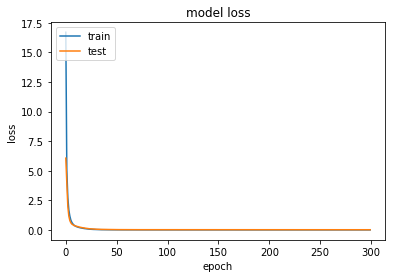

In [65]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
history.history["val_loss"]

[6.0659634577084898,
 3.9979057148711323,
 1.9782237712651083,
 1.156754974633047,
 0.78748301283953936,
 0.59532163853514686,
 0.48691819751099363,
 0.43638315429426222,
 0.37341376975791096,
 0.35379917531797328,
 0.32074053075215586,
 0.2957813715281552,
 0.27804254546557389,
 0.24621346511252939,
 0.22821111017710541,
 0.2175314781600482,
 0.19259995160854027,
 0.17642746763686612,
 0.16876712768045191,
 0.14727199730807788,
 0.14051317923689541,
 0.12680578099129952,
 0.11185402382318288,
 0.099683176981259697,
 0.095407645894240029,
 0.084158385351096113,
 0.082660296293970661,
 0.074982920176770593,
 0.073393871727055068,
 0.063327371002468338,
 0.058297520988199812,
 0.05414024786385771,
 0.052659009570536548,
 0.048576940310327971,
 0.045845607117022555,
 0.044493906710245841,
 0.042814327735606936,
 0.041813067760165426,
 0.038651795241318336,
 0.036578784377811709,
 0.035378966990807288,
 0.033957333061588955,
 0.031960852597266026,
 0.032421037018911476,
 0.0306689974992242

In [67]:
pred_k = model.predict(X_test)
print(mean_squared_error(y_test, pred_k))

0.0156615353542


NN doesn't seem to work........

# Best model

In [68]:
best = StackingAveragedModels(base_models = (m1,m4,m5),
                              meta_model = Lasso(alpha = 0.0003))

In [69]:
best.fit(X.values, y.values)

# Test set predictions

In [70]:
#final_predictions = 10**lr.predict(test_final)
#final_predictions = 10**xgb.predict(test_final)
#final_predictions = [i[0] for i in 10**model.predict(test_final)]
#final_predictions = 10**xgb_best.predict(test_final)
final_predictions = 10**best.predict(test_final.values)

# Submit file

In [71]:
submission = pd.DataFrame({
                           "Id": test["Id"],
                           "SalePrice": final_predictions
                         })
submission.to_csv('Stacked_2.csv', index=False)
